In [1]:
# Load environment variables from parent directory and set up auto-reload
import os

from dotenv import load_dotenv

load_dotenv(os.path.join("..", ".env"), override=True)

%load_ext autoreload
%autoreload 2

## Planning: TODO Lists

#TODO(Geoff): Can add more here. 

* Many agents use a TODO list to enable long-running tasks. 
* Claude Code uses [plan mode](https://www.anthropic.com/engineering/claude-code-best-practices) to create a TODO list prior to executing a task. 
* Manus uses a `todo.md` file to track tasks. 
* This has a few benefits.
* Continuously re-writing and updating a TODO list can help an agent [stay on task](https://manus.im/blog/Context-Engineering-for-AI-Agents-Lessons-from-Building-Manus).
* Writing a TODO list to a file is a useful means of [context offloading](https://blog.langchain.com/context-engineering-for-agents/). 
* TODO list can be persisted and referenced later.
* The latter is critical because agent context can grow quickly.
* The average Manus task uses ~50 tool calls! 
* TODO's buried at the bottom of the context window can be forgotten. 
* Some interesting studies on [this](https://research.trychroma.com/context-rot).
|

In [2]:
%%writefile ../src/deep_agents_from_scratch/state.py

from typing import NotRequired, Annotated, TypedDict, Literal
#TODO(Geoff): What is AgentState
from langgraph.prebuilt.chat_agent_executor import AgentState

# Define Todo state type
class Todo(TypedDict):
    """Todo to track."""

    content: str
    status: Literal["pending", "in_progress", "completed"]

#TODO (Geoff): Role for the file_reducer?
def file_reducer(l, r):
    if l is None:
        return r
    elif r is None:
        return l
    else:
        return {**l, **r}

class DeepAgentState(AgentState):
    todos: NotRequired[list[Todo]]
    files: Annotated[NotRequired[dict[str, str]], file_reducer]

Overwriting ../src/deep_agents_from_scratch/state.py


### Prompt 

In [3]:
from utils import show_prompt

from deep_agents_from_scratch.prompts import WRITE_TODOS_DESCRIPTION

show_prompt(WRITE_TODOS_DESCRIPTION)

╭──────────────────────────────────────────────────── Prompt ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│  Use this tool to create and manage a structured task list for your current work session. This helps you track  │
│  progress, organize complex tasks, and demonstrate thoroughness to the user.                                    │
│                                                                                                                 │
│  ## When to Use This Tool                                                                                       │
│  Use this tool proactively in these scenarios:                                                                  │
│  1. Complex multi-step tasks - When a task requires 3 or more distinct steps or actions                         │
│  2. Non-trivial and complex tasks - Tasks that require careful planning or multiple operations                  │
│  3. User explicitly requests todo list - When the user directly asks you to use the todo list                   │
│  4. User provides multiple tasks - When users provide a list of things to be done                               │
│                                                                                                                 │
│  ## Task States                                                                                                 │
│  - pending: Task not yet started                                                                                │
│  - in_progress: Currently working on (limit to ONE task at a time)                                              │
│  - completed: Task finished successfully                                                                        │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

### Write ToDo Tool 

* We use LangGraph's `Command` type to update the state in the tool call.  

In [4]:
%%writefile ../src/deep_agents_from_scratch/todo_tool.py

from langchain_core.tools import tool
from typing import Literal, Annotated
from langchain_core.tools import InjectedToolCallId
from langchain_core.messages import ToolMessage
from typing_extensions import TypedDict
from langgraph.types import Command
from deep_agents_from_scratch.prompts import WRITE_TODOS_DESCRIPTION
from deep_agents_from_scratch.state import Todo

# The write_todos tool definition
@tool(description=WRITE_TODOS_DESCRIPTION)
def write_todos(
    todos: list[Todo], 
    tool_call_id: Annotated[str, InjectedToolCallId]
) -> Command:
    """Create and manage a structured task list for tracking progress."""
    return Command(
        update={
            "todos": todos,
            "messages": [
                ToolMessage(f"Updated todo list to {todos}", tool_call_id=tool_call_id)
            ],
        }
    )

Overwriting ../src/deep_agents_from_scratch/todo_tool.py


### Graph  

#TODO(Geoff): Here we can explain create_react_agent, esp `state_schema`.

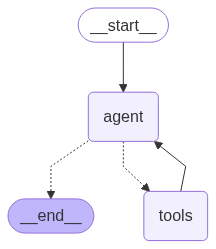

In [5]:
from IPython.display import Image, display
from langchain.chat_models import init_chat_model
from langgraph.prebuilt import create_react_agent
from utils import format_messages

from deep_agents_from_scratch.state import DeepAgentState
from deep_agents_from_scratch.todo_tool import write_todos

# Create agent using create_react_agent directly
model = init_chat_model(model="anthropic:claude-sonnet-4-20250514", temperature=0.0)
tools = [write_todos]

# System prompt for the agent 
system_prompt = """You are a task management assistant. Use the write_todos tool to:
- Break down complex requests into manageable steps
- Track progress with pending/in_progress/completed states
- Only have one task in_progress at a time
- Update status immediately when tasks are finished"""

# Create agent with system prompt
agent = create_react_agent(model, tools, prompt=system_prompt, state_schema=DeepAgentState)

# Show the agent
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

In [6]:
# Example usage
result = agent.invoke({
    "messages": [{"role": "user", "content": "Help me organize a product launch"}],
    "todos": []
})

format_messages(result['messages'])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Help me organize a product launch                                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ I'll help you organize a comprehensive product launch by breaking it down into manageable tasks. Let me create  │
│ a structured task list to guide you through the process.                                                        │
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Define product launch strategy and timeline",                                                 │
│       "status": "pending"                                                                                       │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Conduct market research and competitive analysis",                                            │
│       "status": "pending"                                                                                       │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Develop target audience personas and messaging",                                              │
│       "status": "pending"                                                                                       │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Create marketing materials (website, brochures, presentations)",                              │
│       "status": "pending"                                                                                       │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Plan and execute PR and media outreach strategy",                                             │
│       "status": "pending"                                                                                       │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Set up digital marketing campaigns (social media, email, ads)",                               │
│       "status": "pending"                                                                                       │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Organize launch event or webinar",                                                            │
│       "status": "pending"                                                                                       │
│     },                                                  

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Define product launch strategy and timeline', 'status': 'pending'},          │
│ {'content': 'Conduct market research and competitive analysis', 'status': 'pending'}, {'content': 'Develop      │
│ target audience personas and messaging', 'status': 'pending'}, {'content': 'Create marketing materials          │
│ (website, brochures, presentations)', 'status': 'pending'}, {'content': 'Plan and execute PR and media outreach │
│ strategy', 'status': 'pending'}, {'content': 'Set up digital marketing campaigns (social media, email, ads)',   │
│ 'status': 'pending'}, {'content': 'Organize launch event or webinar', 'status': 'pending'}, {'content':         │
│ 'Prepare sales team with training and materials', 'status': 'pending'}, {'content': 'Establish customer support │
│ processes and FAQ', 'status': 'pending'}, {'content': 'Set up analytics and tracking systems', 'status':        │
│ 'pending'}, {'content': 'Execute soft launch with beta users or limited audience', 'status': 'pending'},        │
│ {'content': 'Launch product publicly and monitor initial response', 'status': 'pending'}, {'content': 'Analyze  │
│ launch metrics and gather feedback', 'status': 'pending'}, {'content': 'Plan post-launch follow-up and          │
│ optimization strategies', 'status': 'pending'}]                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ I've created a comprehensive product launch task list that covers all the essential phases from strategy to     │
│ post-launch analysis. Here's how to approach this systematically:                                               │
│                                                                                                                 │
│ ## **Phase 1: Foundation & Strategy**                                                                           │
│ - Start with defining your launch strategy and timeline                                                         │
│ - Conduct thorough market research                                                                              │
│ - Develop clear target audience personas and messaging                                                          │
│                                                                                                                 │
│ ## **Phase 2: Content & Materials**                                                                             │
│ - Create all necessary marketing materials                                                                      │
│ - Set up digital marketing campaigns                                                                            │
│ - Plan your launch event or presentation                                                                        │
│                                                                                                                 │
│ ## **Phase 3: Team Preparation**                                                                                │
│ - Train your sales team                                                                                         │
│ - Establish customer support processes                                                                          │
│ - Set up tracking and analytics systems                                                                         │
│                                                                                                                 │
│ ## **Phase 4: Launch Execution**                                                                                │
│ - Execute a soft launch first                                                                                   │
│ - Roll out the public launch                                                                                    │
│ - Monitor and analyze performance                                                                               │
│                                                                                                                 │
│ ## **Phase 5: Post-Launch**                                                                                     │
│ - Gather feedback and analyze metrics                                                                           │
│ - Plan optimization strategies                                                                                  │
│                                                                                                                 │
│ **Next Steps:**                                                                                                 │
│ 1. Which task would you like to start with first?                                                               │
│ 2. Do you have a specific timeline in mind for your launch?                                                     │
│ 3. Are there any specific aspects of the launch you'd like to focus on or modify in this list?                  │
│                                                                                                                 │
│ Let me know which task you'd like to begin with, and I'll update it to "in_progress" and provide detailed       │
│ guidance for that specific step!                       